In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pyvista
from cycler import cycler
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
from loadingData import *
from loadingDynamicalData import *
import seaborn
import pickle
from scipy.interpolate import griddata
from matplotlib import cm

def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

## Version

To reproduce the results, The `CPC` tags of Kratos and ROM_AM should be installed. Using later/other versions can induce errors.

Previously trained ROMs are stored in the form of `.pkl` files in the `./trainedROMs` folder.
Those ROMs are constructed as described in this notebook, using MacOs 12.6 (arm64), Apple Clang 13.0.0 and Python 3.11. The `numpy` version is `1.24.3`.


# FSI Configuration

We consider the problem first introduced in [[1]](#References), and illustrated below, where an incompressible flow in a $2D$ channel faces a massless elastic body with two mounted flaps behind a rigid cylinder.

!["setting"](./figs/wake_DoubleFlap.png)

For the fluid, the Navier-Stokes equations read
\begin{equation}
    \begin{cases}
        \rho_f \dfrac{\partial \pmb{v}}{\partial t}_{|\tilde{\mathcal{A}}} + \rho_f [(\pmb{v} - \pmb{w}).\nabla]\pmb{v} + \nabla p - 2 \,\pmb{\text{div}}(\mu_f \pmb{D}(\pmb{v})) = 0 \quad \text{in}\ \Omega_f(t)\\[1.3ex]
        \nabla\cdot\pmb{v}= 0 \quad \text{in }\ \Omega_f(t)\\[1.3ex]
    \end{cases}    
\end{equation}

with $p$ the fluid pressure, $\rho_f$ the fluid density, $\mu_f$ the fluid dynamic viscosity and $\pmb{D}(\pmb{v})$ is the fluid strain rate tensor. The fluid equations are described on a moving domain (using the ALE moving frame) $\Omega_f(t)$. The notation $\tilde{\mathcal{A}}$ represents the ALE mapping from the reference domain (the $t=0$ configuration) to the computational domain and $\pmb{w}$ is the ALE velocity. 

In this case, we have $\rho_f = 1000\ kg/m^3$, $\mu_f = 0.001\ m^2/s$ and a fully developed Poiseuille inlet flow is applied, with a maximum velocity of $v_{max} = 2.5\ m/s$ starting from $v = 0\ m/s$ at $t = 0s$ and increased by a sinusoidal ramp until reaching $v_{max}$ at $t = 1 s$. This corresponds to a Reynolds number of $Re = 250$, based on $v_{max}$ and the cylinder diameter. The boundary condition at the top and bottom walls is a no slip condition, and a zero pressure on the right boundary.

For the solid subproblem, the equilibrium and constitutive equations for a static hyperelastic solid are:

\begin{equation}
\begin{cases}
     \nabla_{\pmb{X}} \pmb{P} = \pmb{0} \quad \text{in}\; \Omega_{s} \\[1.3ex]
    \pmb{P} = \dfrac{\partial W}{\partial \pmb{F}_s} \\[1.3ex]
    \pmb{u} = \pmb{0} \; \quad \text{in}\; \Gamma_{D, s}\\[1.3ex]
\end{cases}  .
\end{equation}

The equations are written in the Lagrangian frame with $\nabla_{\pmb{X}}$ the gradient operator in the original configuration, $\pmb{P}$ is the first Piola-Kirchoff stress tensor (PK1) and $\Gamma_{D, s}$ is the Dirichlet boundary. The material model is described in the stored energy density function $W$, here using the hyperelastic Neo-Hookean model:
\begin{equation}
    W(\pmb{F}_s) =  \frac{\lambda_s}{2}\,(ln(J))^2 - \mu_s ln(J) + \frac{\mu_s}{2}(trace(\pmb{C_s}) - 3)
\end{equation}
where $J = det(\pmb{F}_s)$ is the determinant of the deformation gradient tensor $\pmb{F}_s$, $\pmb{C}_s = \pmb{F}_s^T \pmb{F}_s$ is the right Cauchy Green deformation tensor, $\mu_s = \dfrac{E}{2 (1 + \nu_s)}$ and $\lambda_s =\frac{E \nu_s}{(1 + \nu_s)(1 - 2  \nu_s)}$. In this example, $E = 10 \times 10^6$ Pa and $\nu_s = 0.3$.

The fluid problem is discretized using $5440$ variational multiscale (VMS) finite elements and $1640$ quadrilateral plane strain finite elements are used for the structural problem, with 8 ($X$ and $Y$) displacement degrees of freedom at element nodes, making a total of $N_S = 3610$ solid dofs. The fluid time step is $\Delta t = 8\times10^{-3}$ s and the second-order "Bossak" time integration scheme is used.

The mesh (`.mdpa`) files are located in `./meshData/`.

# Making the Reduced Order Models

![imgg](../../figs/CoupledClasses.png)

Data corresponding to the elastic tube simulation with $Re = \{179, 208, 250\}$ (corresponding to viscosity values of $\{1.4, 1.2, 1.0\}~kg.m^{-1}.s{-1}$) was stored in the form of numpy arrays in the `trainingData/` folder. The simulation snapshots of solid displacement, fluid loads and the number of iterations per time step. Note that the data also contains the output of the intermediate subiterations, and not just the converged results.

In [2]:
# Loading the data as numpy arrays
# The data include subiterations up to the 425th time step (t = 3.4s).
# The rest of the data (up to the 750th time step) can be used for testing.

tr_disp_data, tr_load_data, _, _, _, _ = bringLoadDispData(425, 750)

## Solid ROMs

The solid ROM can be constructed and trained using the `solid_ROM` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Quadratic manifolds for the displacement field reduction $r_u = 9$ retaining $99.99%$ of the energy.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;POD for load field reduction the $r_f = 45$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$2^{nd}$ order polynomial regression with Lasso optimization.

In [3]:
from rom_am.solid_rom import solid_ROM

t0 = time.time()
sol_rom = solid_ROM()
sol_rom.train(tr_load_data, tr_disp_data,
              rank_pres=45, rank_disp=.9999,
              regression_model="PolyLasso",
              dispReduc_model="QUAD",
              forcesReduc_model="POD",
              map_used = np.load("./meshData/map_used.npy"),
              to_copy=[False, False],
              norm_regr=[False, False])
t1 = time.time()


In [4]:
print("Training wall time is ", t1 - t0, " s")

Training wall time is  63.36573815345764  s


## Fluid ROMs

The fluid ROM can be constructed and trained using the `FluidSurrog` class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_f = 45$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The solid `RomDimensionalityReducer` accessed through `sol_rom.dispReduc_model` is passed as an argument for the fluid ROM.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RBF interpolation with cubic kernel functions as the regression model.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Retraining of the regressor is done after each $Z = 200$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The constant size of training batch is $p = 6900$.

In [5]:
_, _, _, trainiterLoadData, trainiterDispData, trainRepflLoadDataConv, \
_,_, _ = bringDynamicalLoadDispData(cutoff_names = ["10", "12", "14"],
                                    cutoff_incr = [450, 450, 450],
                                    trainingData=True)


In [6]:
from rom_am.fluid_surrogate import FluidSurrog

fluidSurr = FluidSurrog(maxLen=6900, reTrainThres = 200)
fluidSurr.train(trainiterDispData, trainRepflLoadDataConv, trainiterLoadData,
                rank_pres=45,
                kernel='cubic', degree = 1, smoothing=9.5e-2,
                solidReduc=sol_rom.dispReduc_model,
                norm=[False, False])


 ----- Load Reduction -----
 ----- Displacement Reduction -----
 ----- Regression -----


The ROMs can be saved with `sol_rom.save("./trainedROMs/solidROM")` and `fluidSurr.save("./trainedROMs/fluidSurrog")`, and then can be loaded for the simulation by indicating the object files in the [`./fsi_ROM_parameters.json`](./fsi_ROM_parameters.json) file.

# Simulation settings

The solid model parameters are defined in [`./ProjectParametersCSM.json`](./ProjectParametersCSM.json) and [`./StructuralMaterials.json`](./StructuralMaterials.json). The fluid model parameters in [`./ProjectParametersCFD.json`](./ProjectParametersCFD.json) and [`./FluidMaterials.json`](./FluidMaterials.json).

The coupling settings can be set in the [`./fsi_ROM_parameters.json`](./fsi_ROM_parameters.json) file.

<table>
<tr>
<th>Coupling parameter</th>
<th>Parameter choice</th>
<th>Associated hypermarameters</th>
</tr>
<tr>
<td>Coupling formulation</td>
<td>Accelerated Gauß-Seidel  $\mathcal{F}(\mathcal{S}(\boldsymbol{f})) = \boldsymbol{f}$</td>
<td>Tolerance $\epsilon = 0.005$</td>
</tr>
<tr>
<td>Convergence acceleration</td>
<td>IQN-ILS</td>
<td>$d=50$, $q=3$, $w_0=0.5$</td>
</tr>
<tr>
<td>Predictors</td>
<td>Constant *vs* Linear *vs* Quadratic *vs* Data-Driven</td>
<td>Tolerance $\epsilon_r = 2.10^{-2}$, $w_0=0.04$</td>
</tr>
</table>

The simulation results are saved in the `./coSimData/` folder, and the `vtk` files are saved in the `vtk_output_fsi_cfd` and `vtk_output_fsi_csm` folders.

# Post-processing

The results of the pressure field, section area field, velocity field and number of iterations are stored in the `results/` folder.

**To replicate those results**, a `README` file inside each `results/` subfolder shows the `json`settings to be modified.

## ROM-FOM results

We show a plot of the training data in the reduced space (POD space), and we highlight the difference between the (fluid) solver sirect output $\tilde{\boldsymbol{f}}$ and the accelerated forces $\boldsymbol{f}$. (See [the coupling scheme figure](../../figs/Scheme.png).)

/Users/azzeddinetiba/Desktop/FSI-ROM-Predictor/examples/twoFsiFlaps/plotreducedpoints.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout();


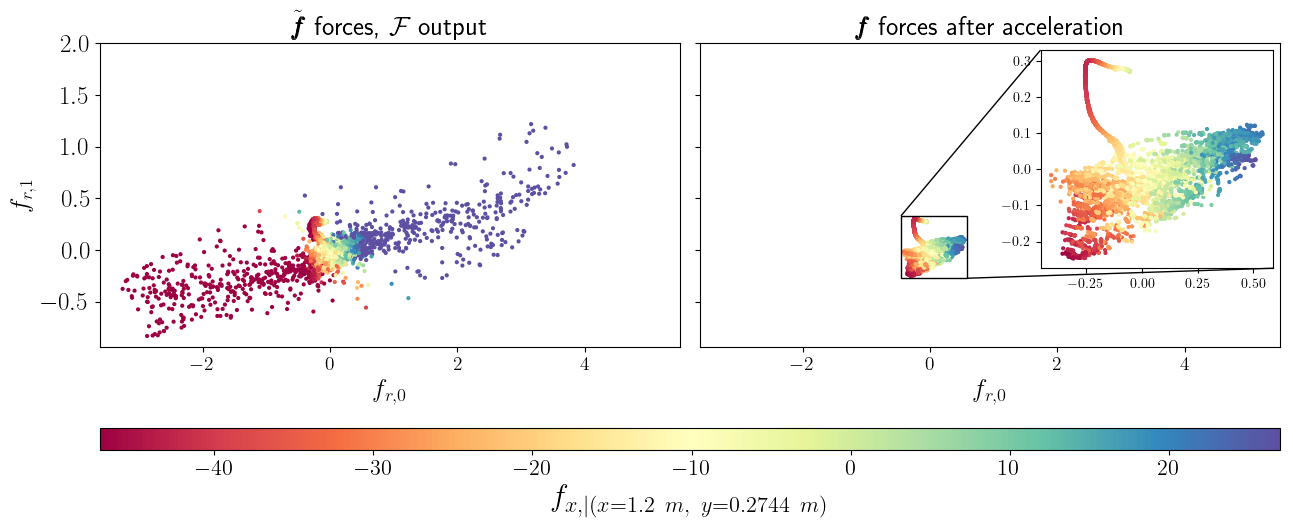

In [7]:
_, tr_load_data_small, _, _, _, _ = bringLoadDispData(425, 750)
_, tr_load_data, _, _, _, _ = bringLoadDispData(425, 750, acceleratedData=False)

acceleratedPoints = sol_rom.forcesReduc.pod.pod_coeff # The solid ROM is trained on
rawPoints = sol_rom.forcesReduc.encode(tr_load_data)


rawColors = tr_load_data[418]
acceleratedColors = tr_load_data_small[418]
cmax = np.max(acceleratedColors)
cmin = np.min(acceleratedColors)
fig, ax = plt.subplots(1, 2, figsize = (13, 4.25), sharex=True, sharey=True);
from plotreducedpoints import plotReducedPoints
plotReducedPoints(fig, ax, rawPoints, acceleratedPoints, rawColors, acceleratedColors, cmin, cmax)


/Users/azzeddinetiba/Desktop/FSI-ROM-Predictor/examples/twoFsiFlaps/plotreducedpoints.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout();


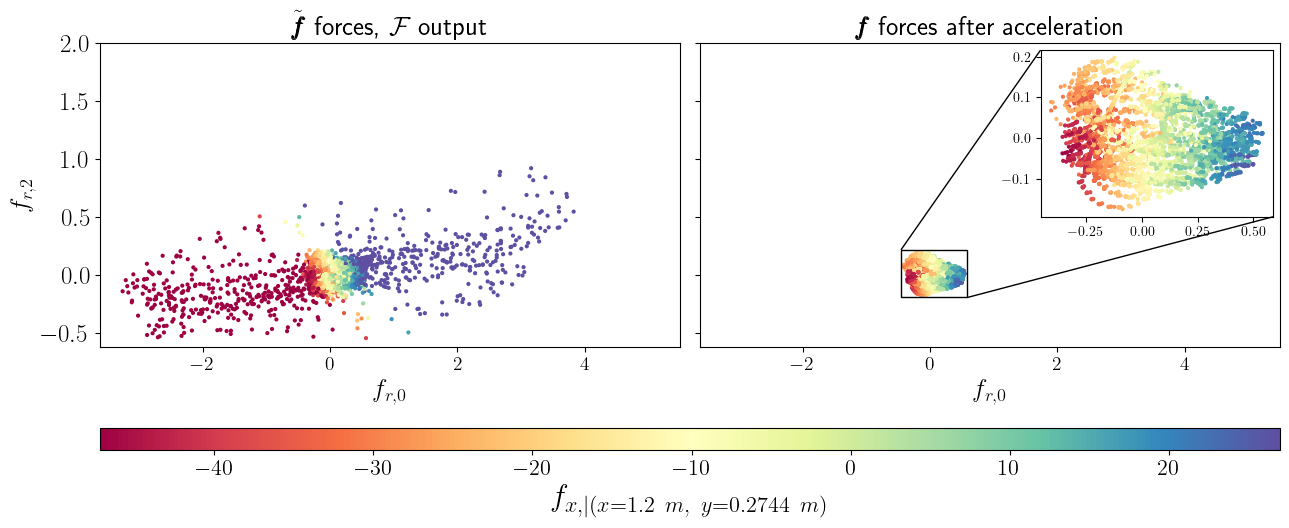

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (13, 4.25), sharex=True, sharey=True);
plotReducedPoints(fig, ax, rawPoints, acceleratedPoints, rawColors, acceleratedColors, cmin, cmax, coords=[0, 2])


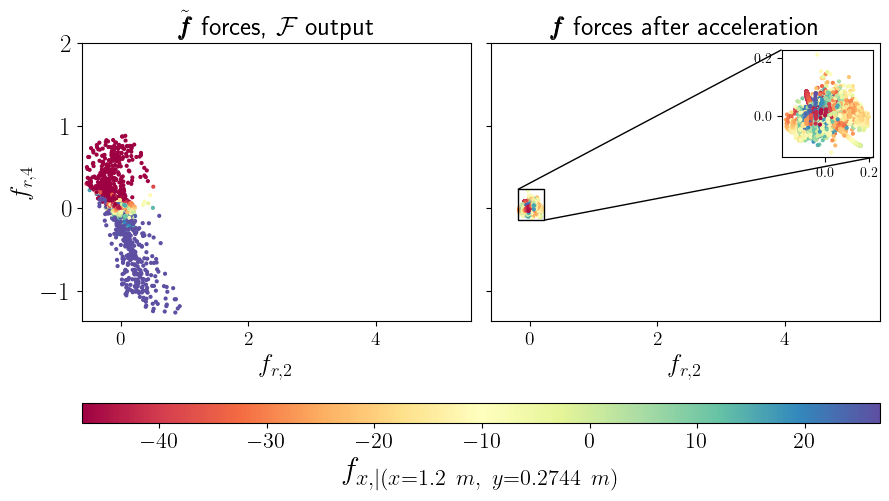

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (9, 4), sharex=True, sharey=True);
plotReducedPoints(fig, ax, rawPoints, acceleratedPoints, rawColors, acceleratedColors, cmin, cmax, coords=[2, 4])


This shows one of the reasons why the coupling scheme $\mathcal{F}(\mathcal{S}(\boldsymbol{f}))$ was used: **The input field (forces in the reudced space) have much less variance, and much less amplitudes (thus less nonlinearities) when approximating the solid that takes the accelerated forces**.

-------------------------------------------------------------------------------------------------------------

We show an example of the force field acting on the deformed solid, $t=4.7~s$.

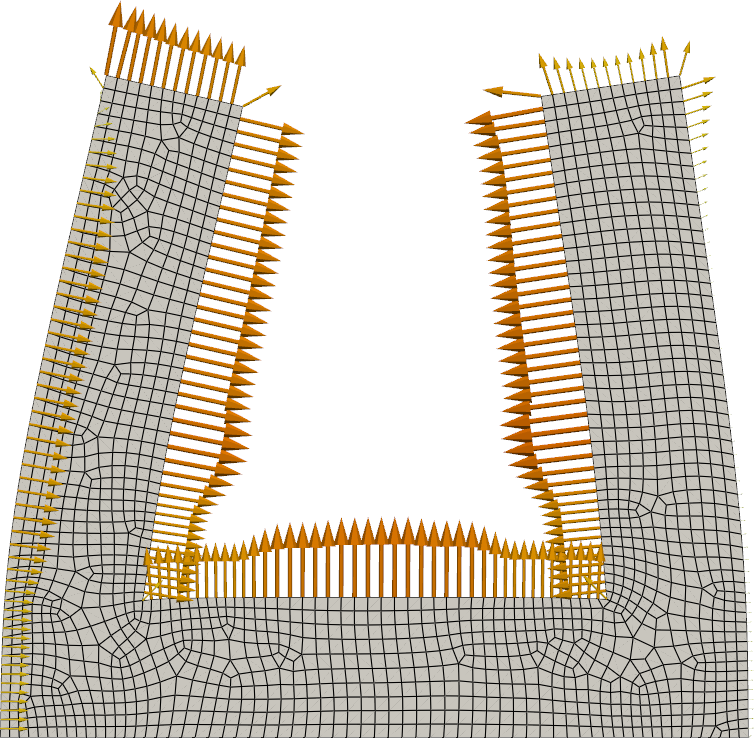

In [10]:
v = "13"
dt = .008

msh = pyvista.read("./results/FOM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_588.vtk")
displacement_X = np.empty((msh.points.shape[0], 1))
displacement_Y = np.empty((msh.points.shape[0], 1))
displacement_X[:, 0] = msh.point_data["DISPLACEMENT"][:, 0]
displacement_Y[:, 0] = msh.point_data["DISPLACEMENT"][:, 1]
#warped = msh.warp_by_vector('DISPLACEMENT');
vectors = msh["POINT_LOAD"]
vectors[1804] = 0.0
msh["vectors"] = vectors * 0.00047

p = pyvista.Plotter(window_size=[4000, 738]);
p.add_mesh(msh, show_edges = True, show_scalar_bar=False, scalars=None, color='white');
pts = msh.points.copy()
up_pts = pts + msh.point_data["DISPLACEMENT"]
p.update_coordinates(up_pts, mesh = msh, render=False)
arrows = msh.glyph(orient="vectors", scale="vectors")
p.add_mesh(arrows, show_edges = False, show_scalar_bar=False, component='None', cmap = 'Wistia',);

p.view_xy();
p.camera.zoom('tight');
p.show(jupyter_backend='static');
#p.screenshot("forcesSolid.png", transparent_background=True);

The nonlinearity of the model (hyperelastic solid) can be seen in the reconstruction of the stress-strain law. We show here the yy component of the PK2 stress tensor as a function of the yy stretch $\lambda_{yy}$.

$\lambda_{yy} = \sqrt{1 + 2 E_{yy}}$ where $E_{yy}$ is the yy component of the Green Lagrange tensor.

In [11]:
E = 10000000.0
mu = 0.3

v = "13"
dt = .008
msh = pyvista.read("./results/FOM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

PK_X = np.empty((msh.cells_dict[9].shape[0], 1000))
PK_Y = np.empty((msh.cells_dict[9].shape[0], 1000))
PK_princ = np.empty((msh.cells_dict[9].shape[0], 1000))
lin_sig_Y = np.empty((msh.cells_dict[9].shape[0], 1000))

STR_Y = np.empty((msh.cells_dict[9].shape[0], 1000))
stretch = np.empty((msh.cells_dict[9].shape[0], 1000))
stretch_Y = np.empty((msh.cells_dict[9].shape[0], 1000))

time = np.arange(0, 1000)*dt
for i in range(1000):
    msh = pyvista.read("./results/FOM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    strains = msh.cell_data["GREEN_LAGRANGE_STRAIN_VECTOR"]
    sts = msh.cell_data["PK2_STRESS_VECTOR"]

    PK_X[:, i] = msh.cell_data["PK2_STRESS_VECTOR"][:, 0]
    PK_Y[:, i] = msh.cell_data["PK2_STRESS_VECTOR"][:, 1]
    STR_Y[:, i] = strains[:, 1]
    stretch_Y[:, i] = np.sqrt(1 + 2*strains[:, 1])

    for j in range(msh.cells_dict[9].shape[0]):
        tensoris = np.array([[strains[j, 0],strains[j, 2]], [strains[j, 2],strains[j, 1]]])
        PKtensoris = np.array([[sts[j, 0],sts[j, 2]], [sts[j, 2],sts[j, 1]]])

        lambs, vecs = np.linalg.eigh(tensoris)
        stretch[j, i] = np.sqrt(1 + 2*lambs[-1])
        PK_princ[j, i] = vecs[:, -1].T @ (PKtensoris @ vecs[:, -1])

PK_X_ROM = np.empty((msh.cells_dict[9].shape[0], 1000))
PK_Y_ROM = np.empty((msh.cells_dict[9].shape[0], 1000))
STR_Y_ROM = np.empty((msh.cells_dict[9].shape[0], 1000))
stretch_Y_ROM = np.empty((msh.cells_dict[9].shape[0], 1000))

for i in range(1000):
    msh = pyvista.read("./results/ROM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")
    strains = msh.cell_data["GREEN_LAGRANGE_STRAIN_VECTOR"]
    PK_X_ROM[:, i] = msh.cell_data["PK2_STRESS_VECTOR"][:, 0]
    PK_Y_ROM[:, i] = msh.cell_data["PK2_STRESS_VECTOR"][:, 1]
    stretch_Y_ROM[:, i] = np.sqrt(1 + 2*strains[:, 1])
    lin_sig_Y[:, i] = (E/((1+mu)*(1-2*mu)))*(mu * strains[:, 0] + (1-mu)*strains[:, 1])

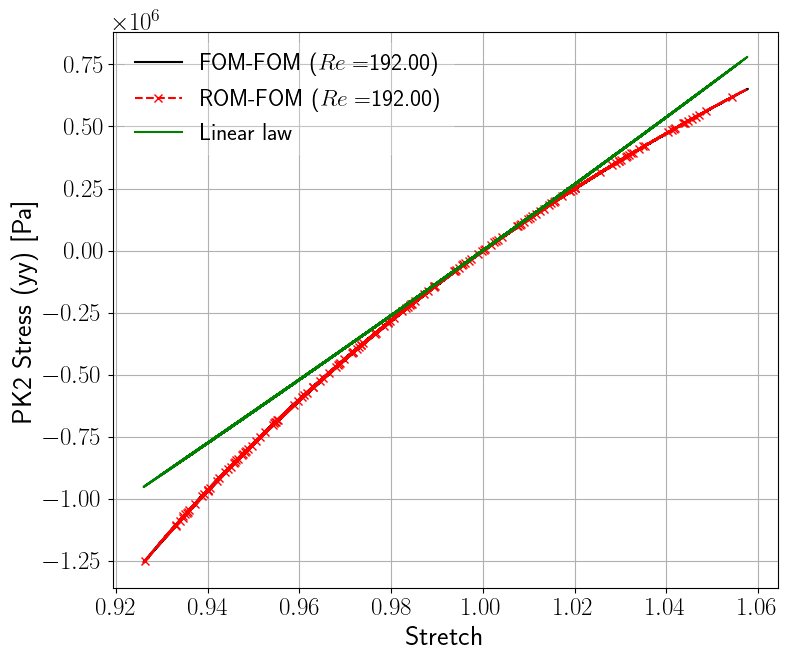

In [12]:
Re = 192
figure, ax = plt.subplots(figsize = (8, 6.7));
which_elem = 259
start_pred = 100

plt.plot(stretch_Y[which_elem, start_pred:], PK_Y[which_elem, start_pred:], 'k-', label = r'FOM-FOM ($Re = $'+"%.2f" %Re+')',);
plt.plot(stretch_Y_ROM[which_elem, start_pred:], PK_Y_ROM[which_elem, start_pred:], 'x--',  markevery = 6, color = 'red',
         label = r'ROM-FOM ($Re = $'+"%.2f" %Re+')',);
plt.plot(stretch_Y_ROM[which_elem, :], lin_sig_Y[which_elem, :], color = 'green', label = 'Linear law',);

ax.set_xlabel("Stretch", fontsize = 20);
ax.set_ylabel("PK2 Stress (yy) [Pa]", fontsize = 20);

ax.tick_params(axis='both', which='major', labelsize = 18)
ax.tick_params(axis='both', which='minor', labelsize = 18)
ax.yaxis.offsetText.set_fontsize(18)

legend = plt.legend(loc = 'best', framealpha = .25,  prop={'size': 17})
frame = legend.get_frame()
frame.set_color('white')
plt.grid();
plt.tight_layout();


-------------------------------------------------------------------------------------------------------------

We show theleft tip displacement as a function of time, when comparing the FOM-FOM solution to the ROM-FOM solution, with the unseen $Re = 192$. It is thus a time-parameter prediction since the model was trained on $Re \in \{179, 208, 250\}$ and $t<=3.4s$.


In [13]:
start_pred = 425
dt = .008

v = "14"
msh = pyvista.read("./results/FOM-FOM/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

displacement_X_14 = np.empty((msh.points.shape[0], 425))
displacement_Y_14 = np.empty((msh.points.shape[0], 425))
timeTr = np.arange(0, 425)*dt
for i in range(425):
    msh = pyvista.read("./results/FOM-FOM/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    displacement_X_14[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_14[:, i] = msh.point_data["DISPLACEMENT"][:, 1]

v = "12"
msh = pyvista.read("./results/FOM-FOM/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

displacement_X_12 = np.empty((msh.points.shape[0], 425))
displacement_Y_12 = np.empty((msh.points.shape[0], 425))
time = np.arange(0, 425)*dt
for i in range(425):
    msh = pyvista.read("./results/FOM-FOM/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    displacement_X_12[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_12[:, i] = msh.point_data["DISPLACEMENT"][:, 1]


v = "10"
msh = pyvista.read("./results/FOM-FOM/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

displacement_X_10 = np.empty((msh.points.shape[0], 425))
displacement_Y_10 = np.empty((msh.points.shape[0], 425))
time = np.arange(0, 425)*dt
for i in range(425):
    msh = pyvista.read("./results/FOM-FOM/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    displacement_X_10[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_10[:, i] = msh.point_data["DISPLACEMENT"][:, 1]

v = "13"
msh = pyvista.read("./results/FOM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

displacement_X_FOM = np.empty((msh.points.shape[0], 1001))
displacement_Y_FOM = np.empty((msh.points.shape[0], 1001))
time = np.arange(0, 1001)*dt
for i in range(1001):
    msh = pyvista.read("./results/FOM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    displacement_X_FOM[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_FOM[:, i] = msh.point_data["DISPLACEMENT"][:, 1]

v = "13"
msh = pyvista.read("./results/ROM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

displacement_X_ROM = np.empty((msh.points.shape[0], 1001))
displacement_Y_ROM = np.empty((msh.points.shape[0], 1001))
time = np.arange(0, 1001)*dt
for i in range(1001):
    msh = pyvista.read("./results/ROM-FOM/13/ConstantExtrapolation/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    displacement_X_ROM[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_ROM[:, i] = msh.point_data["DISPLACEMENT"][:, 1]


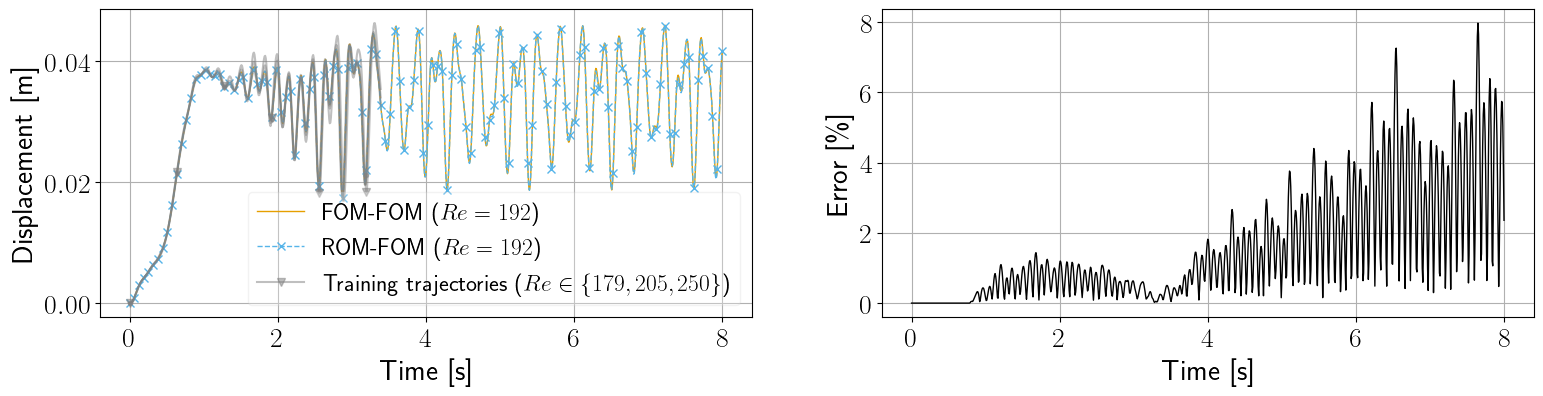

In [14]:
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                   #"--", "-.", ":", "-", "--", "-."
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))


figure, ax = plt.subplots(1, 2, figsize=(18.5, 4))

node = 1488
ax[0].set_prop_cycle(line_cycler)
ax[0].plot(time, displacement_X_FOM[node, :], label = r'FOM-FOM ($Re = 192$)', linewidth = 1.0);
ax[0].plot(time, displacement_X_ROM[node, :], 'x--',  markevery = 8,
         label = r'ROM-FOM ($Re = 192$)', linewidth = 1.0);

ax[0].plot(timeTr, displacement_X_10[node, :], 'grey', alpha = 0.5, label = r'Training trajectories ($Re \in \{179, 205, 250\}$)',);
ax[0].plot(timeTr, displacement_X_12[node, :], 'grey', alpha = 0.5);
ax[0].plot(timeTr, displacement_X_14[node, :], 'grey', alpha = 0.5);

ax[0].set_ylabel("Displacement [m]", fontsize = 21);
ax[0].set_xlabel("Time [s]", fontsize = 21);

ax[0].tick_params(axis='both', which='major', labelsize = 20)
ax[0].tick_params(axis='both', which='minor', labelsize = 20)
#ax.set_xticklabels([])
legend = ax[0].legend(loc = 'best', framealpha = .25,  prop={'size': 17})
ax[0].grid();

error = 100.*(np.linalg.norm(displacement_X_FOM - displacement_X_ROM, axis = 0))/(np.mean(np.linalg.norm(displacement_X_FOM, axis = 0)))
ax[1].plot(time, error, 'black', linewidth = 1.0);

ax[1].set_ylabel("Error [\%]", fontsize = 21);
ax[1].set_xlabel("Time [s]", fontsize = 21);

ax[1].tick_params(axis='both', which='major', labelsize = 20)
ax[1].tick_params(axis='both', which='minor', labelsize = 20)
#ax.set_xticklabels([])
ax[1].grid();


## Iteration results

We can show the accumulated number of iterations along the simulation time, comparing the efficacy of the classical predictors and the new data-driven predictor.

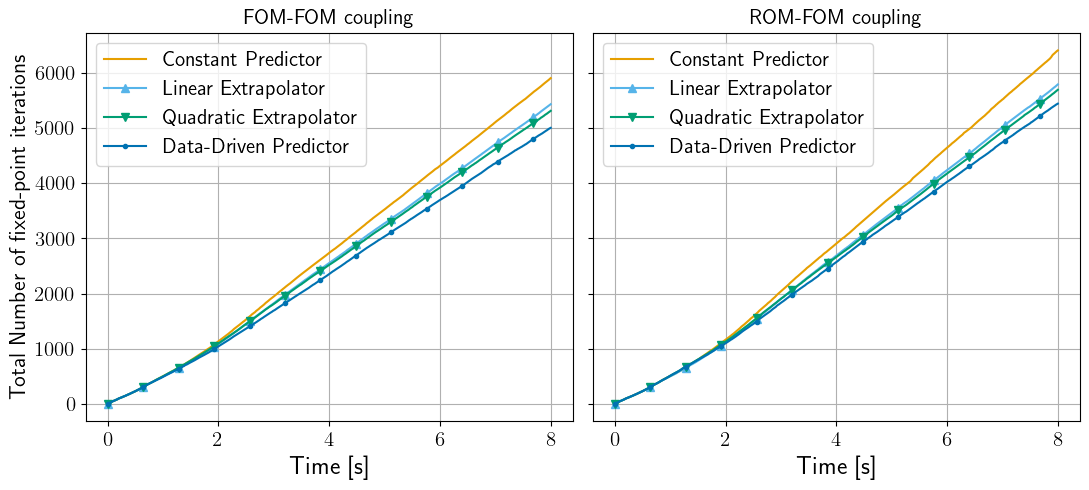

In [15]:
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "-","-","-","-","-","-",
                                  ],
                       marker=["", "^", "v", ".", "", "", ""],
                       markevery=[80, 80, 80, 80, 80, 80, 80]))


fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
ax[0].set_prop_cycle(line_cycler)
ax[1].set_prop_cycle(line_cycler)
time_ = np.arange(0.0, 8.008, 0.008)


ax[1].set_title("ROM-FOM coupling", fontsize = 15);
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/13/ConstantExtrapolation/coSimData/iters.npy")), label='Constant Predictor');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/13/LinearExtrapolation/coSimData/iters.npy")), label='Linear Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/13/QuadraticExtrapolation/coSimData/iters.npy")), label='Quadratic Extrapolator');
ax[1].plot(time_, np.cumsum(np.load("./results/ROM-FOM/13/SurrogatePrediction/coSimData/iters.npy")), label='Data-Driven Predictor');

ax[0].set_title("FOM-FOM coupling", fontsize = 15);
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/13/ConstantExtrapolation/coSimData/iters.npy")), label='Constant Predictor');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/13/LinearExtrapolation/coSimData/iters.npy")), label='Linear Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/13/QuadraticExtrapolation/coSimData/iters.npy")), label='Quadratic Extrapolator');
ax[0].plot(time_, np.cumsum(np.load("./results/FOM-FOM/13/SurrogatePrediction/coSimData/iters.npy")), label='Data-Driven Predictor');


ax[0].set_ylabel("Total Number of fixed-point iterations", fontsize = 16);
ax[0].set_xlabel("Time [s]", fontsize = 18);
ax[1].set_xlabel("Time [s]", fontsize = 18);
ax[0].legend(fontsize = 15);
ax[1].legend(fontsize = 15);

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)


ax[0].grid();
ax[1].grid();

plt.tight_layout();

More specifically, we can see the effect of the new predictors on the accuracy of the initial guess, measuring it using the residual of the FSI fixed point problem. An example is shown here below.

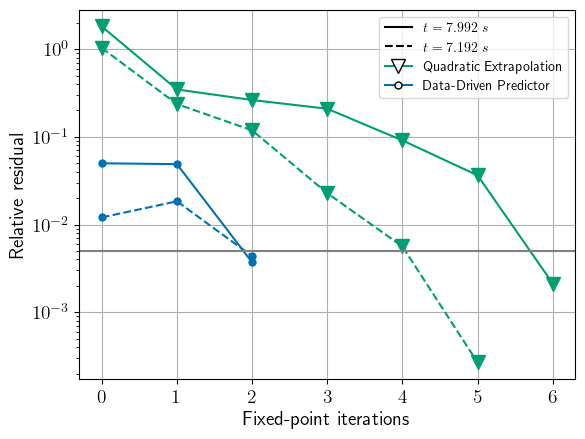

In [16]:
old = np.load("./results/FOM-FOM/13/QuadraticExtrapolation/coSimData/iters.npy")
new = np.load("./results/FOM-FOM/13/SurrogatePrediction/coSimData/iters.npy")
min_= min(len(old), len(new))

line_cycler   = (cycler(color=["#009E73", "#0072B2", "#009E73", "#0072B2", "#0072B2", "#009E73"]) +
                 cycler(linestyle=["-", "-","--","--","-","--"],
                       marker=["v", ".", "v", ".", "", ""],
                       markevery=[1, 1, 1, 1, 1, 1],markersize = [10, 10, 10, 10, 10, 10]))

fig, ax = plt.subplots()
ax.set_prop_cycle(line_cycler)

increm = 999
#increm = np.random.randint(101, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/FOM-FOM/13/QuadraticExtrapolation/coSimData/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/FOM-FOM/13/SurrogatePrediction/coSimData/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);
firsT = str(increm*0.008)

increm = 899
#increm = np.random.randint(101, min_)
itersCurrentQuad_1 = old.cumsum()[increm]
itersCurrentQuad_0 = itersCurrentQuad_1 - old[increm]
itersCurrentSurr_1 = new.cumsum()[increm]
itersCurrentSurr_0 = itersCurrentSurr_1 - new[increm]
ax.semilogy(np.load("./results/FOM-FOM/13/QuadraticExtrapolation/coSimData/rRelNorm.npy")[itersCurrentQuad_0:itersCurrentQuad_1]);
ax.semilogy(np.load("./results/FOM-FOM/13/SurrogatePrediction/coSimData/rRelNorm.npy")[itersCurrentSurr_0:itersCurrentSurr_1]);
secondT = str(increm*0.008)


ax.set_xlabel("Fixed-point iterations", fontsize = 14);
ax.set_ylabel("Relative residual", fontsize = 14);

color = np.array([["#E69F00", "#56B4E9"],]*2).transpose()  # Can be other colours than b,g,r
marker0 = ['-', '--']
marker = ['v-', '.-']

#for j in range(3):
#    plt.scatter(x[:,j], y[:,j], c=color[:,j], marker=marker[j])

# legend
label_column = ['Quadratic Extrapolation','Data-Driven Predictor']
label_row = [r'$t='+firsT+'~s$', r'$t='+secondT+'~s$']
rows = [plt.plot([], [], marker0[i], color='k')[0] for i in range(2)]
columns = [plt.plot([], [], marker[i], markerfacecolor='w',
                    markeredgecolor='k')[0] for i in range(2)]

plt.legend(rows + columns, label_row + label_column, loc='best')
ax.axhline(5e-3, color='grey');

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)

plt.grid();

But "How typical are the examples given in the figure above ?".
To answer this question, we can show the distribution of:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- The differences in the number $\Delta{N_{k}^n}$ of iterations at each time step $n$, where $\Delta{N_{k}^n} = N_{k, \text{REF}}^n - N_{k, \text{DD}}$, with $N_{k, \text{REF}}^n$ is the number of iterations-to-convergence with the classical predictors (here comparing the quadratic and constant extrapolations) and $N_{k, \text{DD}}^n$ is the number of iterations-to-convergence using the new data-driven predictor. The occurrence of the $\Delta{N_{k}}^n$ quantities greater than $0$ are indicating a performance gain with the new predictors.
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- he ratios of the initial residuals $\zeta^n$ at each time step $n$, where $\zeta^n = ||\boldsymbol{r}_{\text{REF}}^0||_2^n \;/\; ||\boldsymbol{r}_{\text{DD}}^0||_2^n$. The occurrence of the $\zeta^n$ quantities greater than $1$ are indicating a performance gain with the new predictors.    

In [17]:
surrIters = np.load("results/FOM-FOM/13/SurrogatePrediction/coSimData/iters.npy")
surrFirstIterIndices = (surrIters.cumsum() - surrIters)
surrInitialResiduals = np.load("results/FOM-FOM/13/SurrogatePrediction/coSimData/rNorm.npy")[surrFirstIterIndices]

quadIters = np.load("results/FOM-FOM/13/QuadraticExtrapolation/coSimData/iters.npy")
quadFirstIterIndices = (quadIters.cumsum() - quadIters)
quadInitialResiduals = np.load("results/FOM-FOM/13/QuadraticExtrapolation/coSimData/rNorm.npy")[quadFirstIterIndices]

Iters = np.load("results/FOM-FOM/13/ConstantExtrapolation/coSimData/iters.npy")
FirstIterIndices = (Iters.cumsum() - Iters)
InitialResiduals = np.load("results/FOM-FOM/13/ConstantExtrapolation/coSimData/rNorm.npy")[FirstIterIndices]


differences1 = quadInitialResiduals - surrInitialResiduals
differences2 = quadIters - surrIters
divisions1 = quadInitialResiduals/surrInitialResiduals

differences1ref = InitialResiduals - surrInitialResiduals
differences2ref = Iters - surrIters
divisions1ref = InitialResiduals/surrInitialResiduals

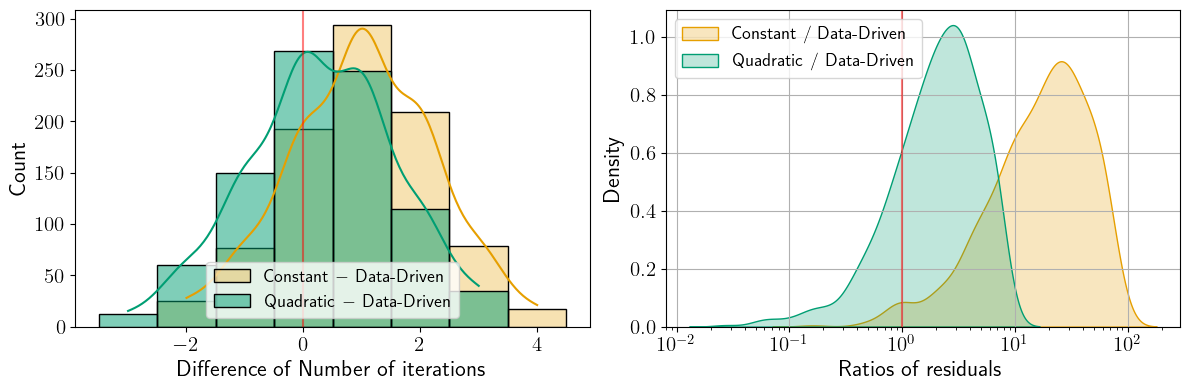

In [18]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
fig, ax = plt.subplots(1, 2, figsize=(12, 4));
plot_data = {'Constant $-$ Data-Driven': reject_outliers(differences2ref)[101:], }
g = seaborn.histplot(plot_data['Constant $-$ Data-Driven'], discrete=True,
                     label = 'Constant $-$ Data-Driven', ax = ax[0],
                     color='#E69F00', fill = True, alpha=.3,
                     kde=True, kde_kws={"bw_adjust":1.4});


plot_data = {'Quadratic $-$ Data-Driven': reject_outliers(differences2)[101:], }
h = seaborn.histplot(plot_data['Quadratic $-$ Data-Driven'], discrete=True,
                     label = 'Quadratic $-$ Data-Driven', ax = ax[0],
                     color='#009E73', fill = True,
                     kde=True, kde_kws={"bw_adjust":1.4});

ax[0].set_xlabel('Difference of Number of iterations', fontsize=16);
ax[0].set_ylabel('Count', fontsize=16);
ax[0].axvline(0, color='red', alpha = 0.5);
ax[0].legend(fontsize=13);
ax[0].tick_params(axis='both', which='major', labelsize = 15);



plot_data = reject_outliers(divisions1ref, m=4)[101:]
seaborn.kdeplot(data=plot_data,
            fill=True, bw_adjust=1., gridsize=2000, ax=ax[1],
                log_scale=True, color="#E69F00",label=r'Constant $/$ Data-Driven'
               );

plot_data = {'Quadratic $/$ Data-Driven': reject_outliers(divisions1, m=4)[101:]}
seaborn.kdeplot(data=plot_data['Quadratic $/$ Data-Driven'], ax = ax[1],
            fill=True, bw_adjust=1., gridsize=2000,
                log_scale=True, color='#009E73', label=r'Quadratic $/$ Data-Driven'
              );
ax[1].legend(loc='upper left', fontsize=13);
ax[1].set_xlabel("Ratios of residuals", fontsize=16);
ax[1].axvline(1, color = 'red', alpha = 0.5);
ax[1].set_ylabel('Density', fontsize=16);
ax[1].grid();
ax[1].tick_params(axis='both', which='major', labelsize = 15);

plt.tight_layout();
fig.savefig("case2DistrubRations.pdf", bbox_inches='tight');

## **ROM update**: Does it matter ?

We show here the effect of the fluid ROM update (retraining of the regressor).
We first compute the error of the ROM prediction of the x-forces (most dominant component), including the training and testing regions.

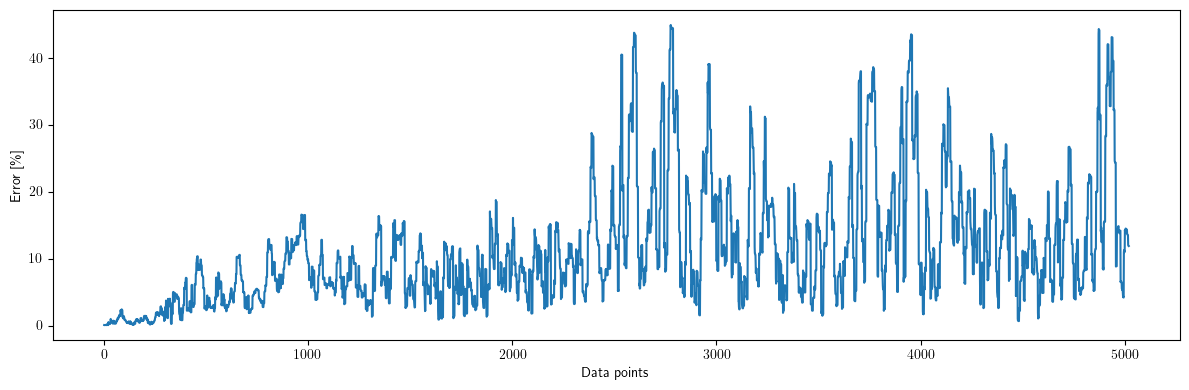

In [20]:
iterLoadData, iterDispData, RepflLoadDataConv, _, _, _, _, _, _ = bringDynamicalLoadDispData()
LoadRecons = fluidSurr.predict(iterDispData, RepflLoadDataConv, solidReduc=sol_rom.dispReduc_model)
error0 = 100*np.max(np.abs(iterLoadData[::2, :] - LoadRecons[::2, :]), axis = 0
               )/np.max(np.abs(iterLoadData[::2, :]))

plt.figure(figsize = (12, 4))
plt.plot(error0);
plt.ylabel(r"Error [\%]");
plt.xlabel(r"Data points");
plt.tight_layout();

The errors are quite large. Then, we iteratively retrain the model on batches unseen data.

In the same way as done in the online simualtions:

&nbsp;&nbsp;&nbsp;&nbsp;1. The model predicts with a pre-trained model in the pffline step (The cell above).

&nbsp;&nbsp;&nbsp;&nbsp;2. New data is added each subiteration with `fluidSurr.augmentData()`.

&nbsp;&nbsp;&nbsp;&nbsp;3. After each $Z=200$ iterations, the regressor is retrained with `fluidSurr._reTrain()`.

To show the effect of this update:

&nbsp;&nbsp;&nbsp;&nbsp;4. After each retraining, we re-evaluate the model on all the available data (obtained from the FOM-FOM offline simulations) and we compute the maximum relative error of the X-forces.

&nbsp;&nbsp;&nbsp;&nbsp;5. We show in the figure the evolution of the mean of this error on the last 1000 subiterations of the avilable data.

In [21]:
errorsMat = []
firstIter = 513 # Corresponds to where the fluid surrogate actually starts adding data during the
                         # coupled simulation
j = 0
for i in range(iterDispData.shape[1] - firstIter):
    fluidSurr.augmentData(iterDispData[:, [firstIter+i]],
                    RepflLoadDataConv[:, [firstIter+i]], iterLoadData[:, [firstIter+i]],
                             solidReduc=sol_rom.dispReduc_model)
    j+=1
    if j > 200:
        fluidSurr._reTrain()
        LoadRecons = fluidSurr.predict(iterDispData, RepflLoadDataConv, solidReduc=sol_rom.dispReduc_model)
        error = 100*np.max(np.abs(iterLoadData[::2, :] - LoadRecons[::2, :]), axis = 0
               )/np.max(np.abs(iterLoadData[::2, :]))
        errorsMat.append(error)
        j = 0


=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===
=== - Retraining the Interpolator - ===


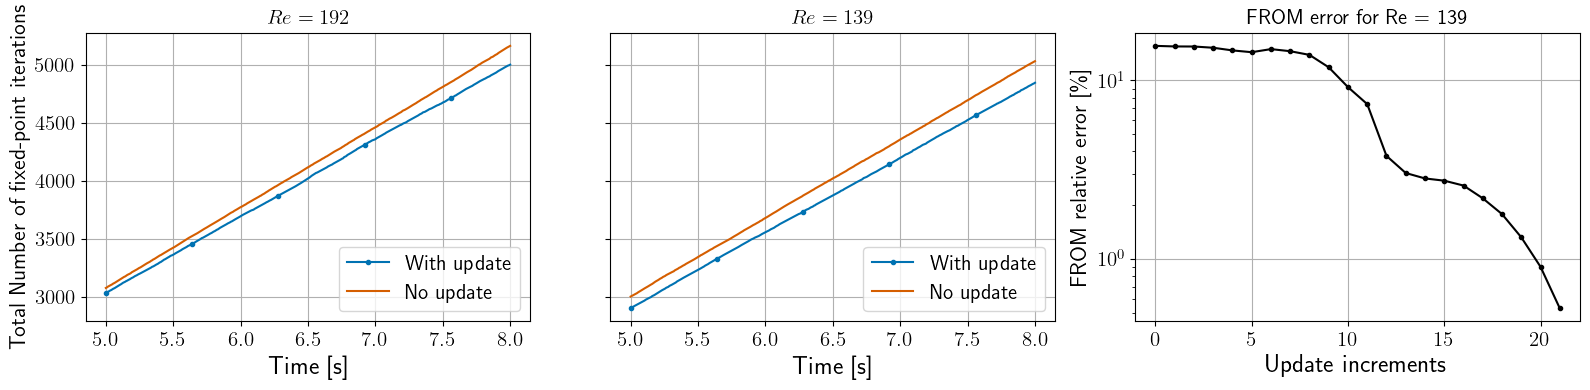

In [22]:
import matplotlib.ticker as ticker

line_cycler   = (cycler(color=["#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-","-","-","-"
                                  ],
                       marker=[".", "", "", ""],
                       markevery=[80, 80, 80, 80]))
fig = plt.figure(figsize=(16, 4))

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2, sharex = ax0, sharey = ax0)
ax2 = fig.add_subplot(1, 3, 3)

ax0.set_prop_cycle(line_cycler)
ax1.set_prop_cycle(line_cycler)
time_ = np.arange(0.0, 8.008, 0.008)


ax1.set_title(r"$Re = 139$", fontsize = 15);
ax1.plot(time_[625:], np.cumsum(np.load("./results/FOM-FOM/18/SurrogatePrediction/coSimData/iters.npy"))[625:],
           label='With update');
ax1.plot(time_[625:], np.cumsum(np.load("./results/FOM-FOM/18/SurrogateNoUpdatePrediction//coSimData/iters.npy"))[625:],
           label='No update');

ax0.set_title(r"$Re = 192$", fontsize = 15);
ax0.plot(time_[625:], np.cumsum(np.load("./results/FOM-FOM/13/SurrogatePrediction/coSimData/iters.npy"))[625:],
           label='With update');
ax0.plot(time_[625:], np.cumsum(np.load("./results/FOM-FOM/13/SurrogateNoUpdatePrediction/coSimData/iters.npy"))[625:],
           label='No update');

ax2.set_title("FROM error for Re = 139", fontsize = 15);
ax2.semilogy(np.mean(np.vstack(errorsMat)[:, -1000:], axis = 1), '.-', color = 'k');


ax0.set_ylabel(r"Total Number of fixed-point iterations", fontsize = 16);
ax0.set_xlabel(r"Time [s]", fontsize = 18);
ax1.set_xlabel(r"Time [s]", fontsize = 18);
ax0.legend(fontsize = 15, loc='lower right');
ax1.legend(fontsize = 15, loc='lower right');
ax2.set_ylabel(r"FROM relative error [\%]", fontsize = 16);
ax2.set_xlabel(r"Update increments", fontsize = 18);

ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


plt.setp(ax1.get_yticklabels(), visible=False)
ax0.grid();
ax1.grid();
ax2.grid();

fig.tight_layout();

# References

[1] [Azzeddine Tiba, Thibault Dairay, Florian De Vuyst, Iraj Mortazavi, Juan-Pedro Berro Ramirez (2024). Machine-Learning Enhanced Predictors for Accelerated Convergence of Partitioned Fluid-Structure Interaction Simulations. arXiv preprint arXiv:2405.09941](https://doi.org/10.48550/arXiv.2405.09941)

[2] [Azzeddine Tiba, Thibault Dairay, Florian De Vuyst, Iraj Mortazavi, Juan-Pedro Berro Ramirez, Non-intrusive reduced order models for partitioned fluid–structure interactions, Journal of Fluids and Structures, Volume 128, 2024, 104156, ISSN 0889-9746.](https://doi.org/10.1016/j.jfluidstructs.2024.104156)